# Outlier Detection Using Statistical Methods

A **point outlier** happens when a data point deviates from the rest of the population. **Collective outlier**, which are groups of observations differ from the population and don't follow the expected pattern. Lastly, **contextual outlier** occur when an observation is considered an outlier based on a particular condition or context, such as a deviation from neighboring data points. *Note that with contextual outliers, the same observations may not be considered an outlier if the context changes*

Another concept, known as **change point detection (CPD)**, relates to outliers detection. In CPD, the goal is to anticipate abrupt and impactful fluctuations (increasing or decreasing) in the time series data. CPD covers specfic techniques such as **cummulative sum (CUMSUM)** and **Bayesian online change point detection (BOCPD)**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [2]:
nyc_data_url = 'https://media.githubusercontent.com/media/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook./main/datasets/Ch8/nyc_taxi.csv'
air_passangers_url = 'https://media.githubusercontent.com/media/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook./main/datasets/Ch8/air_passenger.csv'
temp_failures_url = 'https://media.githubusercontent.com/media/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook./main/datasets/Ch8/machine_temp_failure.csv'

nyc_taxi = pd.read_csv(nyc_data_url,index_col='timestamp',parse_dates=True)
nyc_taxi.index.freq = '30T'

In [3]:
nyc_dates_outliers = ["2014-11-01",
                    "2014-11-27",
                    "2014-12-25",
                    "2015-01-01",
                    "2015-01-27"]

<AxesSubplot:title={'center':'NYC Taxi'}, xlabel='timestamp'>

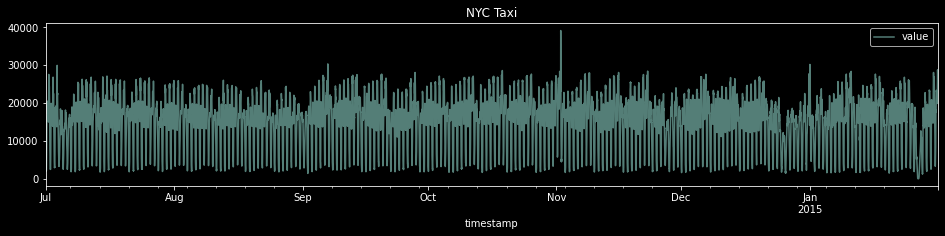

In [4]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

In [5]:
def plot_outliers(outliers, data, method='KNN',
                halignment='right',
                valignment='bottom',
                labels=False):
                ax = data.plot(alpha=0.6)
                if labels:
                    for i in outliers['value'].items():
                        plt.plot(i[0],i[1],'rx')
                        plt.text(i[0],i[1],f'{i[0].date()}',
                                horizontalalignment=halignment,
                                verticalalignment=valignment)
                else:
                    data.loc[outliers.index].plot(ax=ax, style='rx')
                plt.title(f'NYC-Taxi - {method}')
                plt.xlabel('date')
                plt.ylabel('# of passengers')
                plt.legend(['nyc taxi','outliers'])
                plt.show()

## Understanding outliers

The presence of outliers requires special handling and further investigation before hastily jumping to decisions on how to handle them. First you will need to detect them and spot their existance. Domain knowledge can be instrumental in determining whether these identified points are outliers, their impact on our analysis, and how you should deal with them.

Outliers can be indicate bad data due to a random variation in the process (noise), or due to data entry error, bad experiment or natural variation. On other hand, if outliers are natural part of the process, you may need to rethink removing them and opt to keep these data points. In such circumstances, you can rely on non-parametric statistical methods that do not make assumptions on the underlying distribution.  

Generally, outliers can cause side effects when building a model based on strong assumptions on the data distribution; for example, the data is from a Gaussian (normal) distribution. Statistical methods and tests based on assumptions of the underlying distribution are referred to as parametric methods. 

There is no fixed protocol for dealing with outliers, and the magnitude of their impact will vary. For example, sometimes you may need to test your model with outliers and again without outliers to understand the overall impact on your analysis. In other words, not all outliers are created, nor should they be treated equally. However, as stated earlier, having domain knowledge is essential when dealing with these outliers.

A common approach to handling outliers is to delete these data points and not have them be part of the analysis or model development. Alternatively, you may wish to replace the outliers using similar techniques highlighted in Chapter 7, Handling Missing Data, such as imputation and interpolation. Other methods, such as smoothing the data, could minimize the impact of outliers. Smoothing, such as exponential smoothing, is discussed in Chapter 10, Building Univariate Time Series Models Using Statistical. You may also opt to keep the outliers and use more resilient algorithms to their effect.

There are many well-known methods for outlier detection. The area of research is evolving, ranging from basic statistical techniques to more advanced approaches leveraging neural networks and deep learning. In statistical methods, you have different tools that you can leverage, such as the use of visualizations (boxplots, QQ-plots, histograms, and scatter plots), z-score, interquartile range (IQR) and Tukey fences, and statistical tests such as **Grubb's test, the Tietjen-Moore test, or the generalized Extreme Studentized Deviate (ESD) test**. These are basic, easy to interpret, and effective methods.


## Resampling time series data

Resampling is the process of changing the frequency or level of granularity of the data. The need for resampling time series can be driven by the nature of your analysis and at what granular level your data need to be. **Downsampling** you will need to aggregate the data by the mean, median,sum, min or max, etc. On other hand other situations might require you to resample your data from daily to hourly. This process is known as **upsampling**, you must fill using interpolation or imputation techniques.  

In [6]:
# Upsampling:

nyc_taxi.resample('15T').mean().head()

,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [7]:
nyc_taxi.resample('15T').fillna('ffill')

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210
...,...
2015-01-31 22:30:00,27309
2015-01-31 22:45:00,27309
2015-01-31 23:00:00,26591


*resample* method allows you to group rows in a specified time frame. This works by grouping data using the DateTimeIndex, and the frequency provided. 

## Detecting outliers using visualizations

There are two general approaches for using statistical techniques to detect outliers: **parametric and non-parametric**. Parametric methods assume you know the underlying distribution of the data. On the other hand, in non-parametric methods you make no assumptions. 

Using histograms and box-plots are basic non-parametric techniques that can provide insight into the distribution of the data and the presence of outliers. 

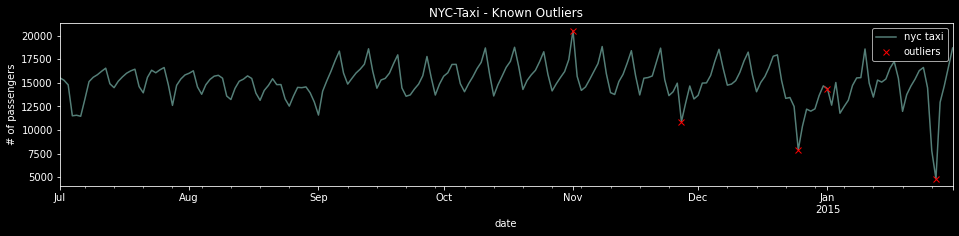

In [8]:
import seaborn as sns

tx = nyc_taxi.resample('D').mean()
known_outliers= tx.loc[nyc_dates_outliers]
plot_outliers(known_outliers, tx, 'Known Outliers')

<AxesSubplot:ylabel='Count'>

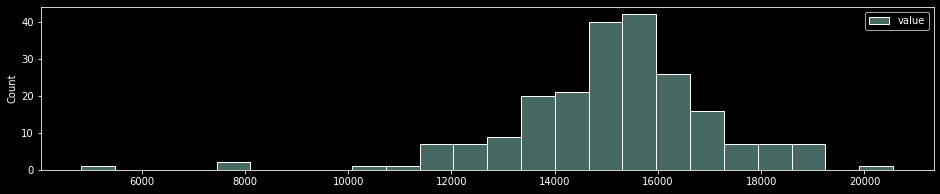

In [9]:
sns.histplot(tx)

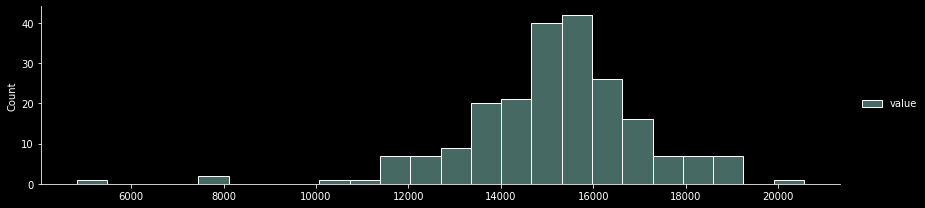

In [10]:
sns.displot(tx, kind='hist', height=3, aspect=4)

<AxesSubplot:xlabel='value'>

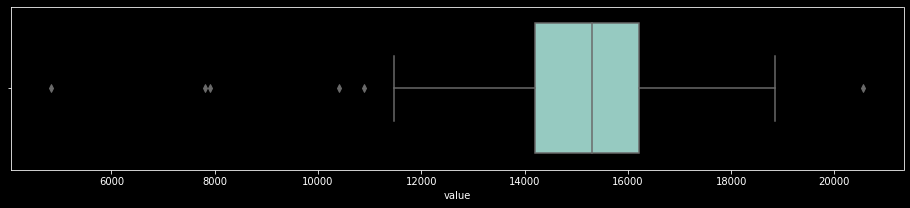

In [11]:
sns.boxplot(tx['value'])

<AxesSubplot:xlabel='value'>

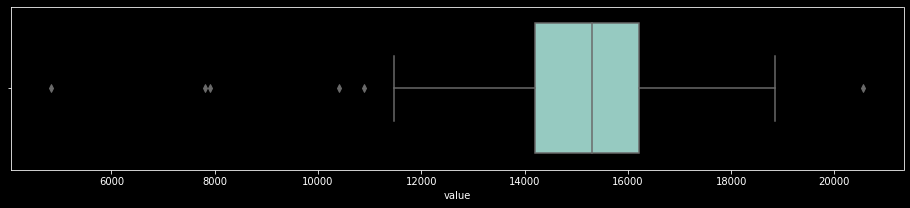

In [12]:
sns.boxplot(tx['value'], whis=1.5)

<AxesSubplot:xlabel='value'>

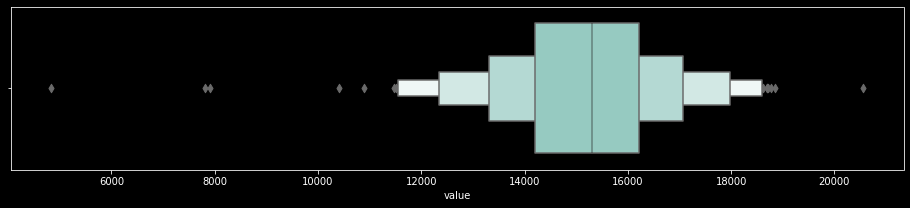

In [13]:
# There are two variations for box-plots in seaborn (boxenplot and violinplot)

sns.boxenplot(tx['value'])

<AxesSubplot:xlabel='value'>

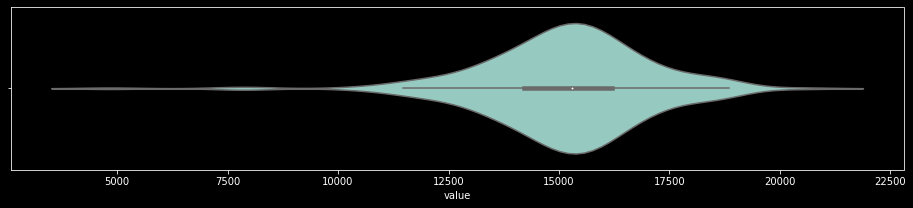

In [14]:
sns.violinplot(tx['value'])

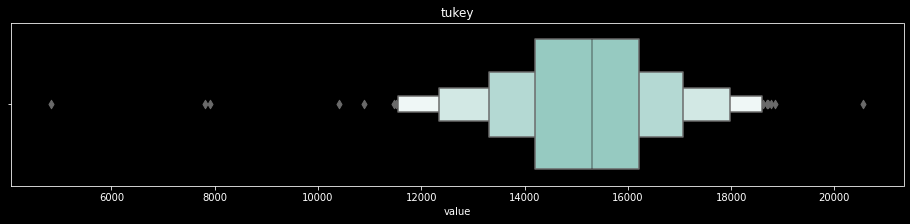

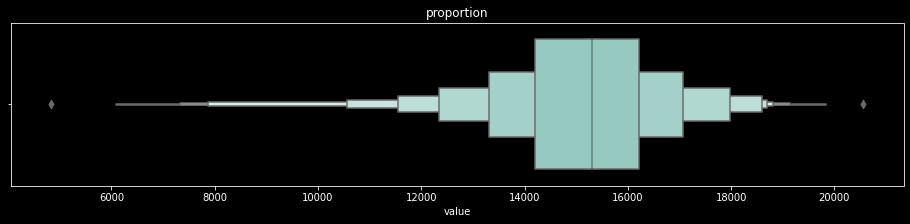

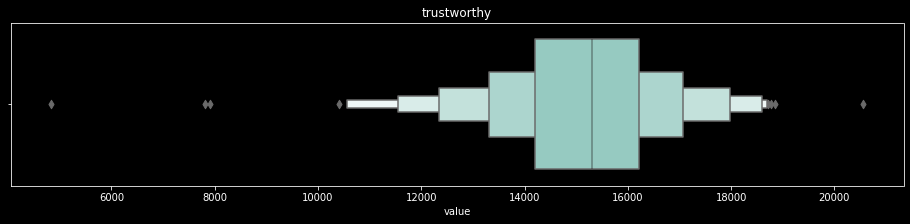

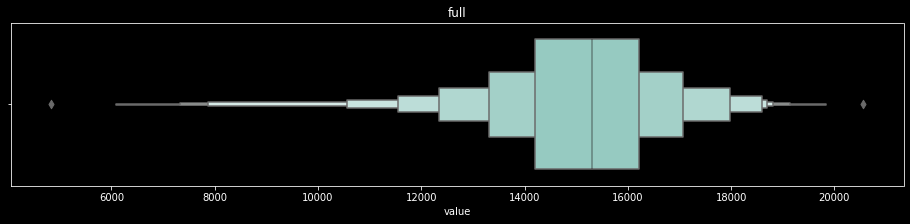

In [15]:
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(tx['value'], k_depth=k)
    plt.title(k)
    plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

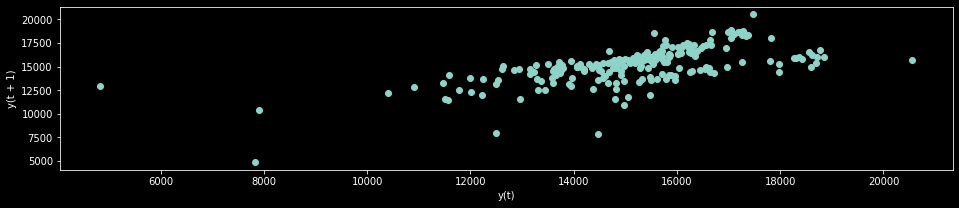

In [16]:
# You can also use lag plot as another useful visualization for spotting outliers. It is essentially a scatter plot, 
# but instead of plotting two variables to observe correlation, we plot the variable against it's lagged version. 

from pandas.plotting import lag_plot
lag_plot(tx)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

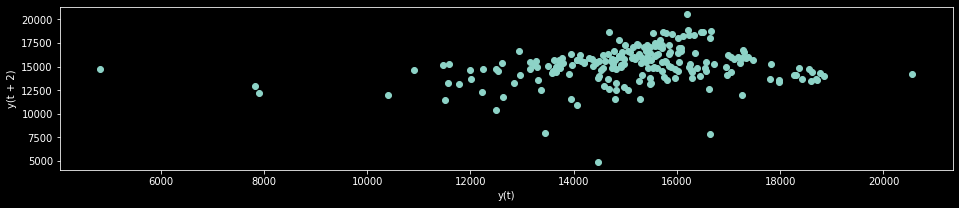

In [17]:
lag_plot(tx,lag=2)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

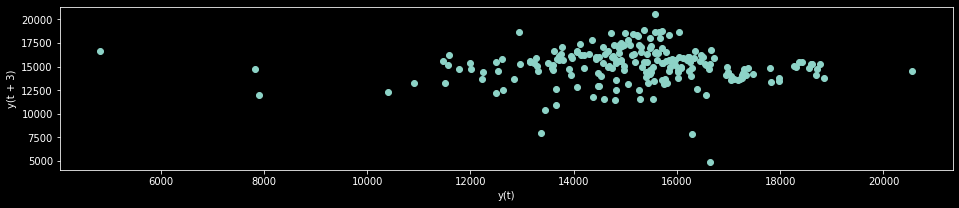

In [18]:
lag_plot(tx,lag=3)

## Detecting outliers using the Turkey method

Most statistical methods allow you to spot extreme values beyond a certain threshold. For example, this could be the mean, standard deviation, the 10th and 90th percentile, etc. You will start be learning how to obtain basic descriptive statistics:

In [19]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


In [20]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

In [21]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [23]:
outliers = iqr_outliers(tx)
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


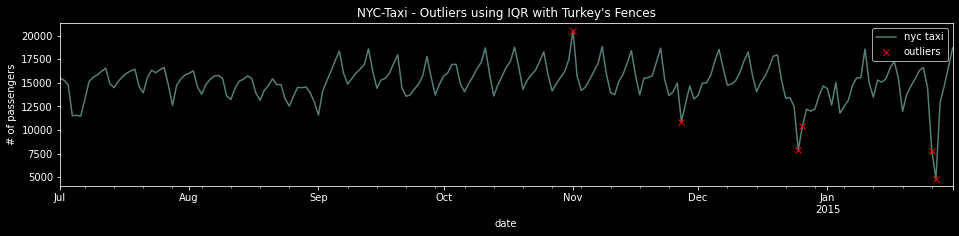

In [25]:
plot_outliers(outliers, tx, "Outliers using IQR with Turkey's Fences")

In [26]:
def iqr_outliers(data, p):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (p * IQR)
    upper_fence = q3 + (p * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [27]:
for p in [1.3, 1.5, 2.0, 2.5, 3.0]:
    print(f'with p={p}')
    print(iqr_outliers(tx, p))
    print('-'*15)

with p=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
---------------
with p=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
---------------
with p=3.0
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  78

## Detecting outliers using the z-score

$$ z = (x - \mu) / \sigma $$

Once the data is transformed using the z-score, you can pick a threshold. So any data point above or below that threshold is considered an outlier. For example, it could be from -3 to +3. Although the z-score has a big assumption, that the distribution of the underlying process is a gaussian. In the case it is not normal, you might need to use the modified version of the z-score:



In [28]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) |
    (data['zscore'] >= degree)]
    return outliers['value'], data

In [29]:
threshold = 2.5
outliers, transformed = zscore(tx, threshold)

array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'zscore'}>]], dtype=object)

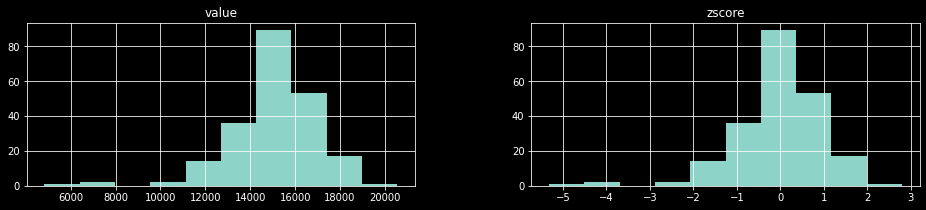

In [30]:
transformed.hist()

In [31]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


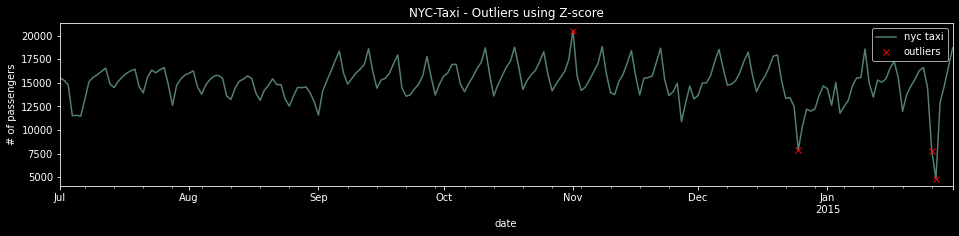

In [32]:
plot_outliers(outliers, tx, "Outliers using Z-score")

In [35]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data)
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

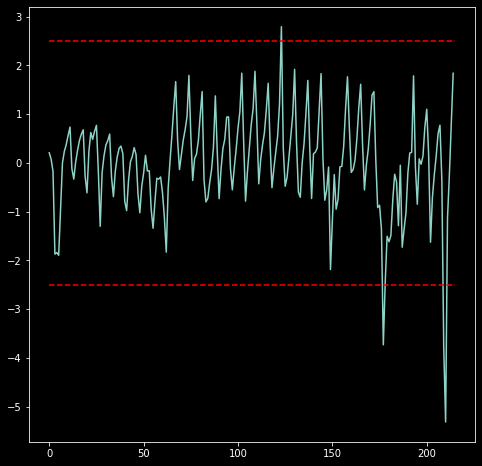

In [36]:
data = transformed['zscore'].values
plot_zscore(data, d=2.5)

There are several test available in the statsmodels library to test if the data is normally distributed. One of the test is the Kolmogorov-Smirnov test. 

In [37]:
from statsmodels.stats.diagnostic import kstest_normal
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [38]:
test_normal(tx)

Reject null hypothesis. Data is not normal


## Detecting using the modified z-score

$$ Modified_{Z} = 0.6745(x_{i}-\tilde{x})/MAD $$

Where the MAD is equal to:

$$ MAD = median(abs(x_{i}-\tilde{x})) $$

The value of 0.6745 is the standard deviation unit that corresponds to the 75th percentile (Q3) in a Gaussian. In other words, it is used to approximate the standard deviation. 

You can obtain this values using the Scipy percent point function(PPF) also known as the inverse cumulative distribution function (CDF). 

In [41]:
from scipy.stats import norm

norm.ppf(0.75)

0.6744897501960817

In [42]:
def modified_zscore(df, degree=3):
    data = df.copy()
    s = norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) |
    (data['m_zscore'] < -degree)]
    return outliers['value'], data

In [43]:
threshold = 3
outliers, transformed = modified_zscore (tx, threshold)

array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'m_zscore'}>]], dtype=object)

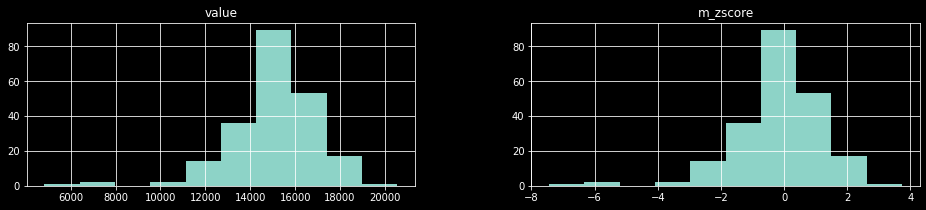

In [44]:
transformed.hist()

In [45]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


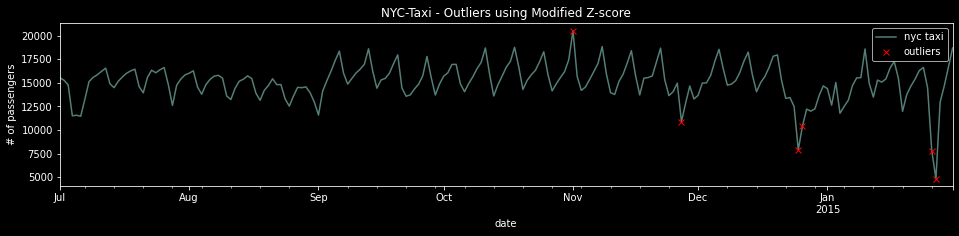

In [46]:
plot_outliers(outliers, tx, "Outliers using Modified Z-score")

In [47]:
def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data)
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

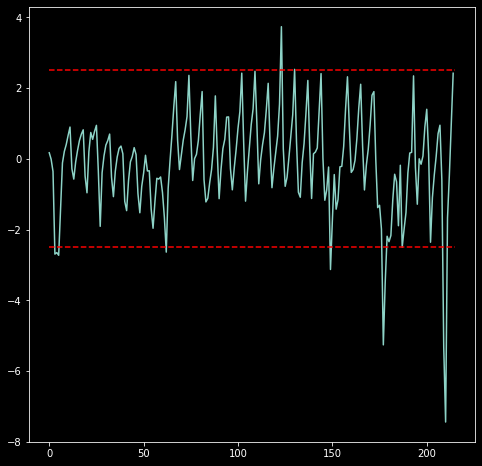

In [48]:
data = transformed['m_zscore'].values
plot_m_zscore(data, d=2.5)

Another helpful plot that is specically designed to test for normality and sometimes can help detect outliers is the Quantile-Quantile plot (QQ-plot)

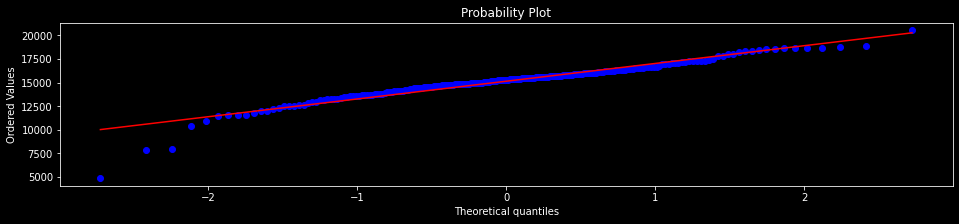

In [49]:
import scipy
import matplotlib.pyplot as plt

res = scipy.stats.probplot(tx.values.reshape(-1), plot=plt)

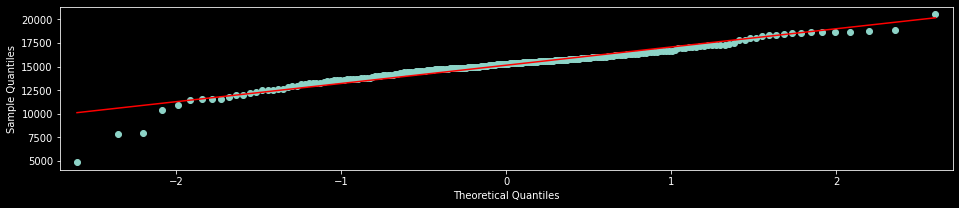

In [50]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx.values.reshape(-1), line='s')
plt.show()